In [42]:
import pandas as pd
import numpy as np
import scipy.stats

In [43]:
#irscrs 2002~2012년데이터
irscrs_2002 = pd.read_excel("../데이터자료/all.xlsx")
#ktb 2002~2012데이터
ktb = pd.read_excel("../데이터자료/ALL_2002_국고채.xlsx")
df = pd.read_excel("../데이터자료/join_data.xlsx")
ktb_2002 = ktb[["DateTime","국고1년","국고3년","국고5년","국고10년","통안1년","통안2년"]]
# irs crs, ktb , 스왑베이시스 2002년 결합
df_2002=pd.merge(ktb_2002,irscrs_2002, how='left', on='DateTime')
# 원래데이터의 필요한것만 가져오기
df_2012=df[['DateTime', '종가_ex','1Y_Mid_irs','2Y_Mid_irs','3Y_Mid_irs','5Y_Mid_irs','10Y_Mid_irs',
 '1Y_Mid_crs','2Y_Mid_crs','3Y_Mid_crs','5Y_Mid_crs','10Y_Mid_crs', 
 '국고1년','국고3년','국고5년','국고10년','통안364일','통안2년', 
 '1Y_베이시스', '2Y_베이시스', '3Y_베이시스', '5Y_베이시스','10Y_베이시스']]

# 2012년도 데이터와의 결합을 위한 컬럼명 통일
df_2002.columns=['DateTime','국고1년','국고3년','국고5년','국고10년','통안364일','통안2년',
                  '1Y_Mid_irs','2Y_Mid_irs','3Y_Mid_irs','5Y_Mid_irs','10Y_Mid_irs',
                   '1Y_Mid_crs','2Y_Mid_crs','3Y_Mid_crs','5Y_Mid_crs','10Y_Mid_crs',
                   '1Y_베이시스', '2Y_베이시스', '3Y_베이시스', '5Y_베이시스','10Y_베이시스']

df_all= pd.concat([df_2002,df_2012]).reset_index(drop='index')

In [16]:
#시간데이터 일치화
df_all["DateTime"] = pd.to_datetime(df_all["DateTime"], format="%Y-%m-%d")
df_all["DateTime"] = df_all["DateTime"].dt.strftime('%Y-%m-%d')


In [17]:
# 월말 영업일 데이터만 추출 시행

# 데이터 인덱스(날짜)를 컬럼으로 형성 후 처음과 끝을 추출

start_date = df_all['DateTime'].astype(str).iloc[0]
end_date = df_all['DateTime'].astype(str).iloc[-1]

# 날짜 처음과 끝에서 영업일 기준 freq 적용 후 데이터 프레임 형성
date_all = pd.date_range(start_date, end_date, freq='B').to_frame().rename(columns={0:'DateTime'}).reset_index(drop=True)
date_all = date_all['DateTime'].astype(str)

# # # # 데이터 병합 (영업일 date와 국체 병합)
df_all = pd.merge(date_all,df_all,how='left')

# # # 직전 값으로 NaN 값 채우기
df_all = df_all.fillna(method='ffill')

# 마지막 영업일 제외후 나머지 drop
df_KR = df_all.set_index(df_all['DateTime'])

# # # 각 월당 마지막 영업일 도출
month_end = pd.date_range('2002-08-01', '2022-08-01', freq='BM')
month_end = month_end.astype(str)

# 마지막 영업일 제외후 나머지 drop
df_all_BM = df_KR[df_KR['DateTime'].isin(month_end)].reset_index(drop=True)
df_all_BM = df_all_BM.set_index(df_all_BM['DateTime'])
df_all_BM = df_all_BM.drop(columns='DateTime')
df_all_BM.head()

,국고1년,국고3년,국고5년,국고10년,통안364일,통안2년,1Y_Mid_irs,2Y_Mid_irs,3Y_Mid_irs,5Y_Mid_irs,...,2Y_Mid_crs,3Y_Mid_crs,5Y_Mid_crs,10Y_Mid_crs,1Y_베이시스,2Y_베이시스,3Y_베이시스,5Y_베이시스,10Y_베이시스,종가_ex
DateTime,,,,,,,,,,,,,,,,,,,,,
2002-08-30,5.03,5.45,5.90,NaN,5.04,5.36,4.96,5.21,5.43,5.89,...,4.82,5.04,5.47,6.08,-25.0,-39.0,-39.0,-42.0,-38.0,NaN
2002-09-30,5.05,5.30,5.65,NaN,5.06,5.30,4.94,5.06,5.22,5.57,...,4.68,4.78,5.09,5.69,-32.0,-38.0,-44.0,-48.0,-42.0,NaN
2002-10-31,5.09,5.33,5.63,NaN,5.09,5.31,5.01,5.07,5.16,5.40,...,4.66,4.73,4.92,5.29,-39.0,-41.0,-43.0,-48.0,-48.0,NaN
2002-11-29,5.05,5.35,5.62,NaN,5.05,5.30,4.93,5.11,5.31,5.55,...,4.70,4.79,4.99,5.23,-28.0,-41.0,-52.0,-56.0,-63.0,NaN
2002-12-31,4.98,5.11,5.34,NaN,4.98,5.12,4.86,4.91,5.04,5.31,...,4.49,4.55,4.71,4.97,-40.0,-42.0,-49.0,-60.0,-63.0,NaN


In [18]:
# # 전월대비 이자율 변화로 할 때 계산
# # df_all_BM_return = df_all_BM - df_all_BM.shift(1)
# ## 전월대비 수익률 변화로 할 때 
# df_all_BM_return = df_all_BM.pct_change()
# df_all_BM_return = pd.DataFrame(df_all_BM_return) * 100
# df_all_BM_return = df_all_BM_return.dropna()

In [19]:
df_all_BM_return = df_all_BM
df_all_BM_return["종가_ex"] = df_all_BM["종가_ex"].pct_change()*100
df_all_BM_return = df_all_BM_return.dropna()

In [20]:
df_all_BM_return

,국고1년,국고3년,국고5년,국고10년,통안364일,통안2년,1Y_Mid_irs,2Y_Mid_irs,3Y_Mid_irs,5Y_Mid_irs,...,2Y_Mid_crs,3Y_Mid_crs,5Y_Mid_crs,10Y_Mid_crs,1Y_베이시스,2Y_베이시스,3Y_베이시스,5Y_베이시스,10Y_베이시스,종가_ex
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-09-28,2.84,2.79,3.02,3.02,2.84,2.83,2.860,2.755,2.750,2.790,...,1.800,1.79,1.45,1.73,-78.0,-95.5,-96.0,-134.0,-123.0,-2.053406
2012-10-31,2.77,2.77,2.96,2.96,2.78,2.79,2.750,2.710,2.710,2.760,...,1.805,1.81,1.65,1.91,-71.0,-90.5,-90.0,-111.0,-103.0,-1.862516
2012-11-30,2.84,2.84,3.03,3.03,2.85,2.83,2.790,2.785,2.790,2.850,...,1.735,1.73,1.56,1.83,-76.0,-105.0,-106.0,-129.0,-121.0,-0.715137
2012-12-31,2.78,2.82,3.16,3.16,2.78,2.82,2.790,2.805,2.820,2.900,...,1.935,1.91,1.59,1.88,-57.0,-87.0,-91.0,-131.0,-124.0,-1.135839
2013-01-31,2.75,2.76,3.10,3.10,2.75,2.76,2.770,2.785,2.800,2.860,...,1.805,1.79,1.74,1.96,-67.0,-98.0,-101.0,-112.0,-111.0,1.718662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,1.81,2.66,2.85,2.96,1.78,2.34,2.135,2.565,2.705,2.715,...,2.000,2.21,2.20,2.29,-62.5,-56.5,-49.5,-51.5,-37.5,0.815104
2022-04-29,1.97,2.95,3.17,3.24,1.89,2.78,2.475,2.915,3.035,3.035,...,2.120,2.40,2.42,2.39,-93.5,-79.5,-63.5,-61.5,-54.5,3.613563
2022-05-31,2.16,3.02,3.25,3.32,2.06,2.85,2.675,3.045,3.125,3.145,...,2.350,2.54,2.57,2.49,-77.5,-69.5,-58.5,-57.5,-61.5,-1.488972


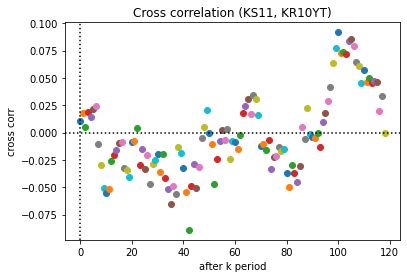

In [21]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['국고1년'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'1년국채와 환율 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

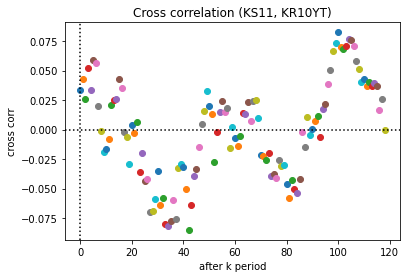

In [22]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['국고3년'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
       # print(f'3년국채와 환율 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

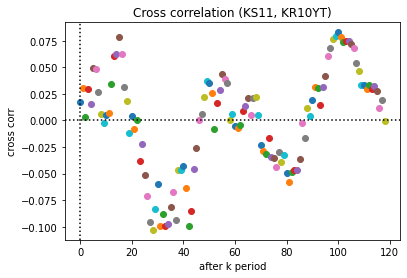

In [23]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['국고5년'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
        # print(f'5년국채와 환율 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

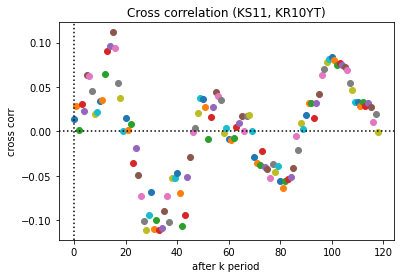

In [24]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['국고10년'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'10년국채와 환율 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

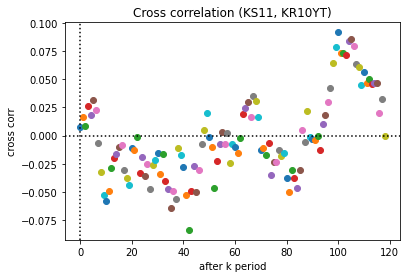

In [25]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['통안364일'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
   # print(f'364일 통안채와 환율 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

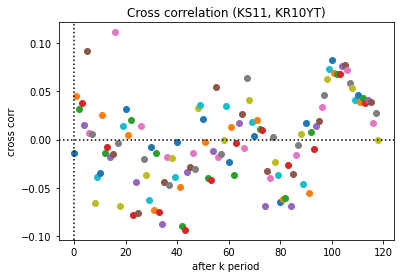

In [26]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['통안2년'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
   # print(f'통안2년채와 환율 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

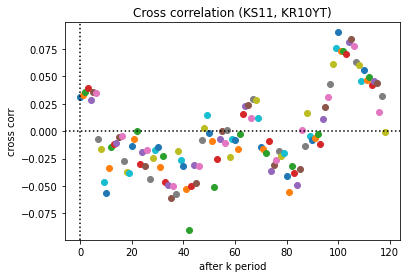

In [27]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['1Y_Mid_irs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'1년 irs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

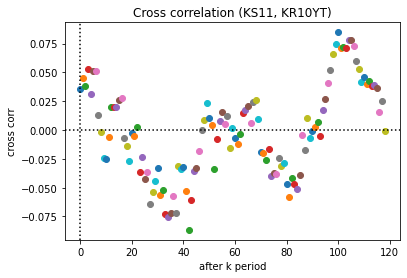

In [28]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['2Y_Mid_irs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'2년 irs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

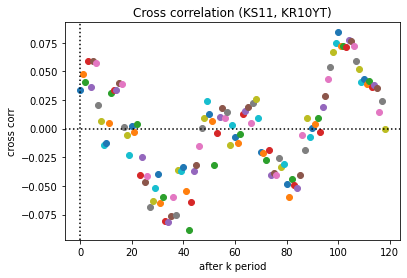

In [29]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['3Y_Mid_irs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'3년 irs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

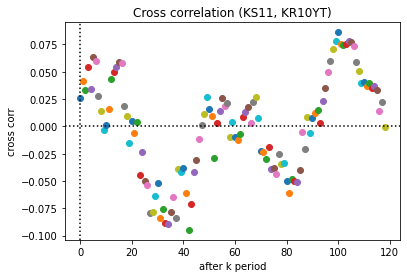

In [30]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['5Y_Mid_irs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'5년 irs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

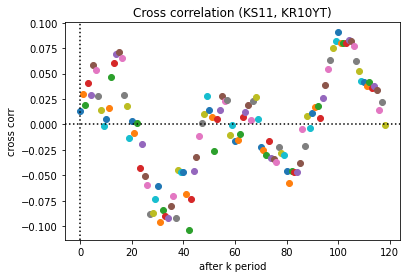

In [31]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['10Y_Mid_irs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'10년 irs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

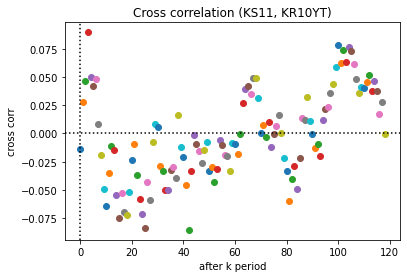

In [32]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['1Y_Mid_crs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'1년 crs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

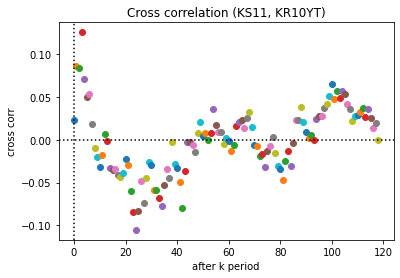

In [33]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['2Y_Mid_crs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'2년 crs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')
    
for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

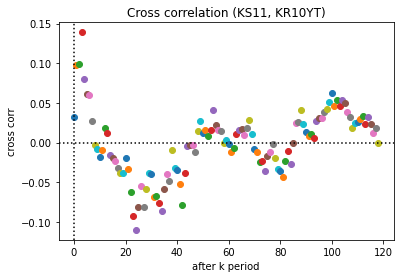

In [34]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['3Y_Mid_crs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'3년 crs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')
    
for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

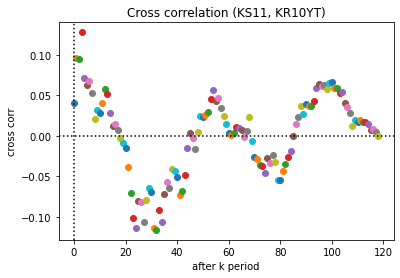

In [35]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['5Y_Mid_crs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'5년 crs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

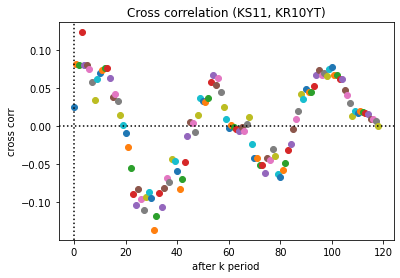

In [36]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['10Y_Mid_crs'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'10년 crs와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

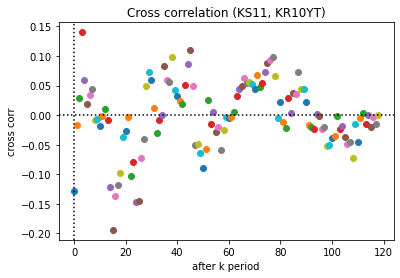

In [37]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['1Y_베이시스'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'1년 베이시스와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()


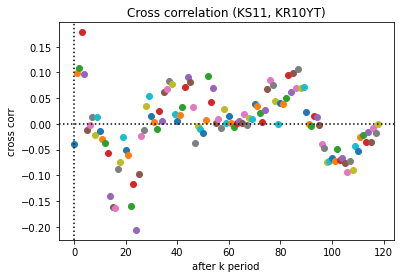

In [38]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['2Y_베이시스'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
   # print(f'2년 베이시스와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

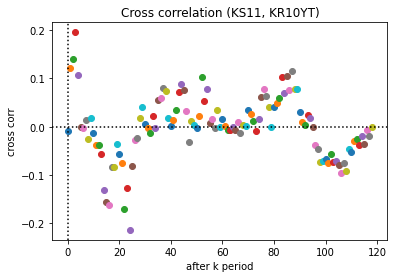

In [39]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['3Y_베이시스'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
   # print(f'3년 베이시스와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

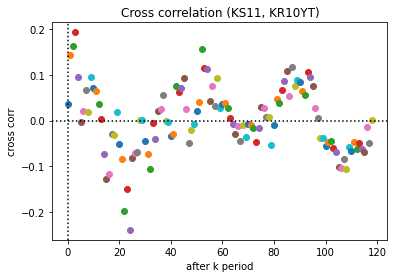

In [40]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['5Y_베이시스'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'5년 베이시스와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()

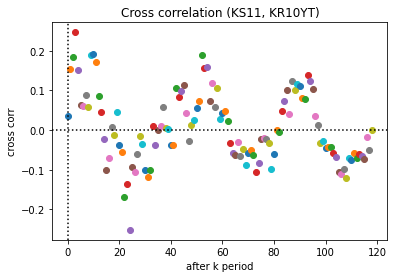

In [41]:
# 나중에 환율 데이터를 더 가지고 오면 이상의 상관성도 볼 수 있음
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

rate_data = np.array(df_all_BM_return['10Y_베이시스'])
exchange_data = np.array(df_all_BM_return['종가_ex'])


cc = sm.tsa.stattools.ccf(exchange_data, rate_data, adjusted=False, fft=True)
#상관계수값 확인하고 싶으면 주석 풀기
# for i in range(119):
    # print(f'10년 베이시스와 환율과의 {i}개월 후 상관계수 값 : {cc[i] : .5f}')

for i in range(119):
    plt.scatter(i, cc[i])
plt.axvline(x=0, color='k' ,linestyle = ':') 
plt.axhline(y=0, color='k' ,linestyle = ':')
plt.title('Cross correlation (KS11, KR10YT)')
plt.xlabel('after k period')
plt.ylabel('cross corr')
plt.show()